In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import pickle

In [43]:
df = pd.read_csv("Cleaned")

In [44]:
df.head()

,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Accident Date,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,Accident Counts,Year,Month,Day,Week
0,429093,436258,1,2009-01-01,Dry,Darkness,Normal,Pedestrian,Slight,Male,44,Car,1,2009,1,1,1
1,434723,435534,1,2009-01-02,Dry,Darkness,Normal,Driver,Serious,Female,23,Car,6,2009,1,2,1
2,441173,433047,1,2009-01-02,Dry,Darkness,Normal,Pedestrian,Slight,Female,12,Car,6,2009,1,2,1
3,428487,431364,1,2009-01-02,Dry,Darkness,Normal,Pedestrian,Slight,Male,15,Car,6,2009,1,2,1
4,425928,435480,2,2009-01-02,Dry,Daylight,Normal,Driver,Slight,Female,34,Car,6,2009,1,2,1


In [45]:
# droping some of columns
df.drop(columns=['Accident Date', "Year", "Month", "Day", "Week"], inplace= True)

In [46]:
df.head()

,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,Accident Counts
0,429093,436258,1,Dry,Darkness,Normal,Pedestrian,Slight,Male,44,Car,1
1,434723,435534,1,Dry,Darkness,Normal,Driver,Serious,Female,23,Car,6
2,441173,433047,1,Dry,Darkness,Normal,Pedestrian,Slight,Female,12,Car,6
3,428487,431364,1,Dry,Darkness,Normal,Pedestrian,Slight,Male,15,Car,6
4,425928,435480,2,Dry,Daylight,Normal,Driver,Slight,Female,34,Car,6


In [47]:
# checking null values
df.isna().sum()

Grid Ref: Easting      0
Grid Ref: Northing     0
Number of Vehicles     0
Road Surface           0
Lighting Conditions    0
Weather Conditions     0
Casualty Class         0
Casualty Severity      0
Sex of Casualty        0
Age of Casualty        0
Type of Vehicle        0
Accident Counts        0
dtype: int64

In [48]:
# handling outlier age columns have a oultier
# Handling outliers
outlier_threshold = 70
df.loc[df['Age of Casualty'] > outlier_threshold, 'Age of Casualty'] = outlier_threshold  # Cap ages above 70 at 70

# Dealing with negative values
df.loc[df['Age of Casualty'] < 0, 'Age of Casualty'] = pd.NA

In [49]:
df.dropna(inplace=True)

In [50]:
# categorical columns for encoding
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [51]:
df.columns

Index(['Grid Ref: Easting', 'Grid Ref: Northing', 'Number of Vehicles',
       'Road Surface', 'Lighting Conditions', 'Weather Conditions',
       'Casualty Class', 'Casualty Severity', 'Sex of Casualty',
       'Age of Casualty', 'Type of Vehicle', 'Accident Counts'],
      dtype='object')

In [52]:
scale_feature = ['Number of Vehicles','Age of Casualty', 'Accident Counts']
ordinal_feature = ['Casualty Severity']
frequency_encoding = ['Road Surface', 'Lighting Conditions', 'Weather Conditions','Casualty Class','Sex of Casualty','Type of Vehicle']
other_columns = ['Grid Ref: Easting', 'Grid Ref: Northing']

In [53]:
# making a class for frequency encoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.frequency_map = {}

    def fit(self, X, y = None):
        for columns in X.columns:
            self.frequency_map[columns] = X[columns].value_counts(normalize = True)
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for columns in X.columns:
            X_encoded[columns] = X_encoded[columns].map(self.frequency_map[columns])
        return X_encoded


In [54]:
# making a pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("prepocessor", ColumnTransformer(transformers = [
        ("num", StandardScaler(), scale_feature),
        ('freq_ecoding', FrequencyEncoder(), frequency_encoding),
        ("ordinal_ecoding", OrdinalEncoder(), ordinal_feature)
    ], remainder= "passthrough"))
])

transformed_data = pipeline.fit_transform(df)

In [55]:
transformed_df = pd.DataFrame(transformed_data,
                              columns= scale_feature + frequency_encoding+ ordinal_feature+ other_columns
                            )

In [56]:
transformed_df.isna().sum()

Number of Vehicles     0
Age of Casualty        0
Accident Counts        0
Road Surface           0
Lighting Conditions    0
Weather Conditions     0
Casualty Class         0
Sex of Casualty        0
Type of Vehicle        0
Casualty Severity      0
Grid Ref: Easting      0
Grid Ref: Northing     0
dtype: int64

In [57]:
with open("preprocessor_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline, file)

# freature selection

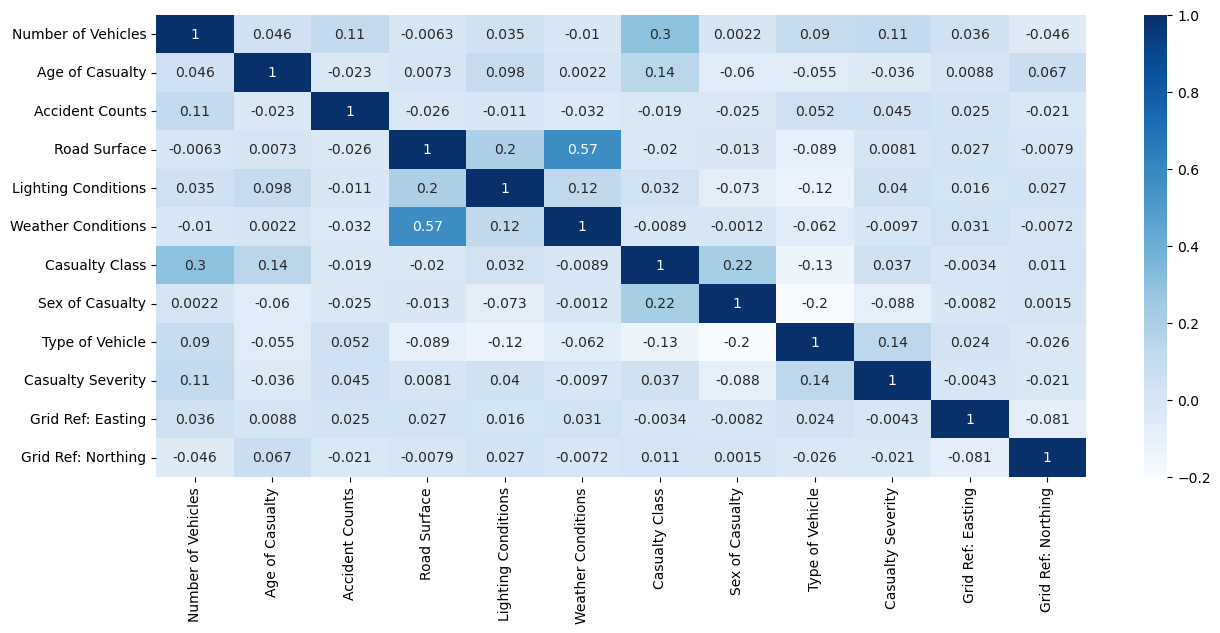

In [58]:
# correlation of features
plt.figure(figsize= (15,6))
sns.heatmap(transformed_df.corr(), annot= True, cmap= "Blues")
plt.show()

In [59]:
corr_matrix = transformed_df.corr()
# Get the column names of the DataFrame
columns = corr_matrix.columns

# Create an empty list to keep track of columns to drop
columns_to_drop = []

# Loop over the columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        # Access the cell of the DataFrame
        if corr_matrix.loc[columns[i], columns[j]] > 0.80:
            columns_to_drop.append(columns[j])

print(len(columns_to_drop))

0


In [60]:
final_df = transformed_df

In [61]:
final_df

,Number of Vehicles,Age of Casualty,Accident Counts,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Sex of Casualty,Type of Vehicle,Casualty Severity,Grid Ref: Easting,Grid Ref: Northing
0,-1.166750,0.528599,-1.925360,0.743082,0.306146,0.876967,0.146453,0.589692,0.706012,2.0,429093.0,436258.0
1,-1.166750,-0.687743,-0.706014,0.743082,0.306146,0.876967,0.588088,0.410308,0.706012,1.0,434723.0,435534.0
2,-1.166750,-1.324875,-0.706014,0.743082,0.306146,0.876967,0.146453,0.410308,0.706012,2.0,441173.0,433047.0
3,-1.166750,-1.151112,-0.706014,0.743082,0.306146,0.876967,0.146453,0.589692,0.706012,2.0,428487.0,431364.0
4,0.085310,-0.050611,-0.706014,0.743082,0.693854,0.876967,0.588088,0.410308,0.706012,2.0,425928.0,435480.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26809,-1.166750,-0.456059,-1.681491,0.238122,0.306146,0.011748,0.588088,0.589692,0.706012,2.0,442094.0,434619.0
26810,-1.166750,0.065231,-1.681491,0.011263,0.693854,0.876967,0.588088,0.589692,0.075520,1.0,423019.0,437653.0
26811,0.085310,1.397416,-1.437622,0.743082,0.693854,0.876967,0.588088,0.589692,0.122473,1.0,436853.0,442515.0
26812,1.337371,0.354836,-1.437622,0.743082,0.306146,0.876967,0.588088,0.589692,0.706012,2.0,421466.0,433999.0


# Applying Clustering Algrothim

In [62]:
# applying a kmeans clusters
# using elbow method for selecting k
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 12):
    km =KMeans(n_clusters= i)
    km.fit_predict(final_df)
    wcss.append(km.inertia_)

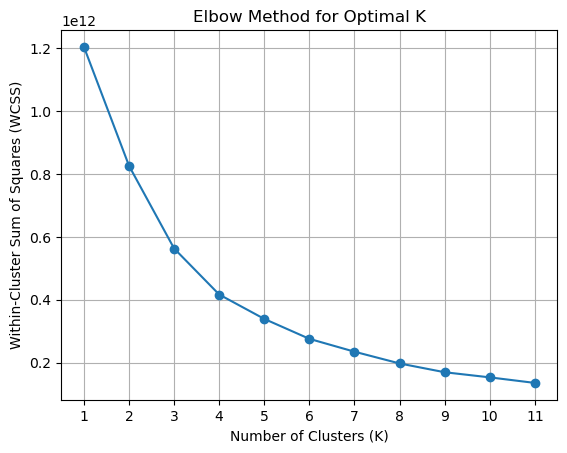

In [63]:
k_values = range(1,12)
# Plot the elbow curve
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [64]:
km = KMeans(n_clusters=4)
km.fit(final_df)

KMeans(n_clusters=4)

In [65]:
#final_df['cluster']  = km.labels_

In [66]:
#final_df

In [67]:
from sklearn.metrics import silhouette_score
# Calculate silhouette score
labels = km.labels_
silhouette_avg = silhouette_score(final_df, labels)

print("Silhouette Score with Best Parameters:", silhouette_avg)

Silhouette Score with Best Parameters: 0.37518009389624624


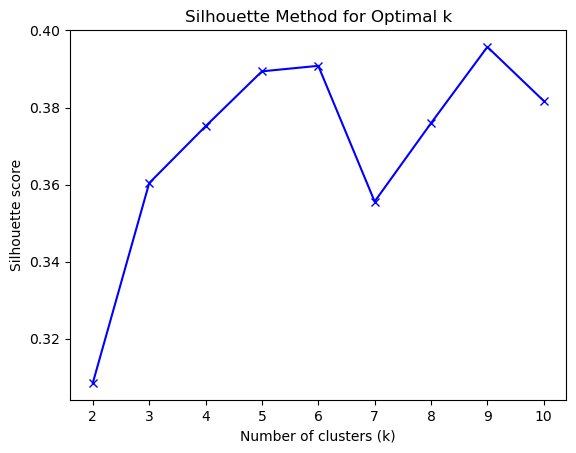

In [68]:
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(final_df)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(final_df, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting silhouette scores for different k values
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [69]:
km = KMeans(n_clusters=5)
km.fit(final_df)

KMeans(n_clusters=5)

In [70]:
final_df['cluster'] = km.labels_

In [71]:
# making a picke file for cluster
with open("cluster.pkl", 'wb') as file:
    pickle.dump(km, file)

In [72]:
final_df.head()

,Number of Vehicles,Age of Casualty,Accident Counts,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Sex of Casualty,Type of Vehicle,Casualty Severity,Grid Ref: Easting,Grid Ref: Northing,cluster
0,-1.16675,0.528599,-1.925360,0.743082,0.306146,0.876967,0.146453,0.589692,0.706012,2.0,429093.0,436258.0,0
1,-1.16675,-0.687743,-0.706014,0.743082,0.306146,0.876967,0.588088,0.410308,0.706012,1.0,434723.0,435534.0,4
2,-1.16675,-1.324875,-0.706014,0.743082,0.306146,0.876967,0.146453,0.410308,0.706012,2.0,441173.0,433047.0,4
3,-1.16675,-1.151112,-0.706014,0.743082,0.306146,0.876967,0.146453,0.589692,0.706012,2.0,428487.0,431364.0,3
4,0.08531,-0.050611,-0.706014,0.743082,0.693854,0.876967,0.588088,0.410308,0.706012,2.0,425928.0,435480.0,1


In [73]:
df['cluster'] = km.labels_

In [74]:
df.head()

,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,Accident Counts,cluster
0,429093,436258,1,Dry,Darkness,Normal,Pedestrian,Slight,Male,44.0,Car,1,0
1,434723,435534,1,Dry,Darkness,Normal,Driver,Serious,Female,23.0,Car,6,4
2,441173,433047,1,Dry,Darkness,Normal,Pedestrian,Slight,Female,12.0,Car,6,4
3,428487,431364,1,Dry,Darkness,Normal,Pedestrian,Slight,Male,15.0,Car,6,3
4,425928,435480,2,Dry,Daylight,Normal,Driver,Slight,Female,34.0,Car,6,1


<Axes: xlabel='Road Surface', ylabel='Accident Counts'>

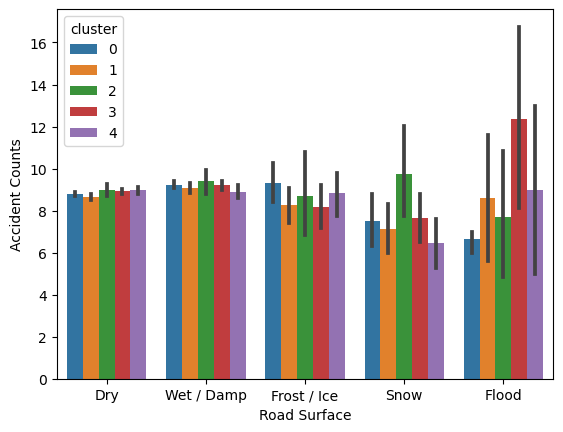

In [75]:
sns.barplot(data = df, x = "Road Surface", y = "Accident Counts", hue = "cluster" )

<Axes: xlabel='Lighting Conditions', ylabel='Accident Counts'>

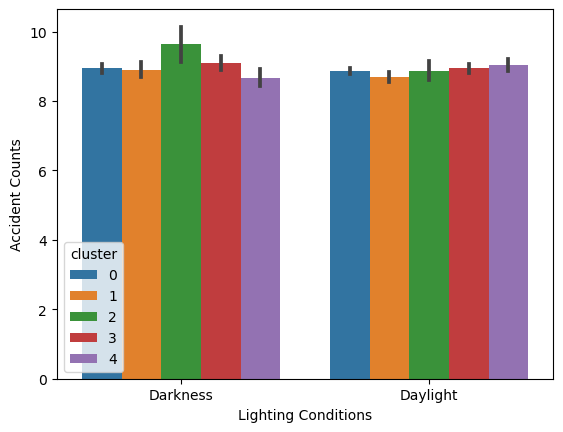

In [76]:
sns.barplot(data = df, x = "Lighting Conditions", y = "Accident Counts", hue = "cluster" )

# Making a inferences file for cluster

In [77]:
# reading a all pickle file

with open("preprocessor_pipeline.pkl", "rb") as file:
    preprocessor = pickle.load(file)

with open("cluster.pkl", "rb") as file:
    model = pickle.load(file)

In [78]:
final_df.columns

Index(['Number of Vehicles', 'Age of Casualty', 'Accident Counts',
       'Road Surface', 'Lighting Conditions', 'Weather Conditions',
       'Casualty Class', 'Sex of Casualty', 'Type of Vehicle',
       'Casualty Severity', 'Grid Ref: Easting', 'Grid Ref: Northing',
       'cluster'],
      dtype='object')

In [79]:
df['Casualty Class'].value_counts()

Driver                          15769
Passenger                        5097
Pedestrian                       3927
Vehicle or pillion passenger     2021
Name: Casualty Class, dtype: int64

In [80]:
# Function to get user input for creating DataFrame
def get_user_input():
    data = {
        'Number of Vehicles': [],
        'Age of Casualty': [],
        'Accident Counts': [],
        'Road Surface': [],
        'Lighting Conditions': [],
        'Weather Conditions': [],
        'Casualty Class': [],
        'Sex of Casualty': [],
        'Type of Vehicle': [],
        'Casualty Severity': [],
        'Grid Ref: Easting': [],
        'Grid Ref: Northing': []
    }

    num_records = int(input("Enter the number of records: "))

    for i in range(num_records):
        print(f"\nEnter details for record {i+1}:")
        data['Number of Vehicles'].append(int(input("Number of Vehicles involved in the accident: ")))
        data['Age of Casualty'].append(int(input("Age of person involved in the accident: ")))
        data['Accident Counts'].append(int(input("Count of accidents happened on that date: ")))
        data['Road Surface'].append(input("Road Surface at the time of accident (Dry/Wet/Damp/Frost/Ice/Snow/Flood): "))
        data['Lighting Conditions'].append(input("Lighting conditions at the time of accident (Daylight/Darkness): "))
        data['Weather Conditions'].append(input("Weather conditions at the time of accident (Normal/Raining/Windy/Snowing/Fog): "))
        data['Casualty Class'].append(input("Casualty class (Driver/Passenger/Pedestrian/Vehicle or pillion passenger): "))
        data['Sex of Casualty'].append(input("Gender of person involved in the accident (Male/Female): "))
        data['Type of Vehicle'].append(input("Type of vehicle involved in the accident (Car/Truck/Bus/Pedal Cycle/Bike): "))
        data['Casualty Severity'].append(input("Casualty severity (Fatal/Serious/Slight): "))
        data['Grid Ref: Easting'].append(int(input("Grid Reference Easting: ")))
        data['Grid Ref: Northing'].append(int(input("Grid Reference Northing: ")))

    return pd.DataFrame(data)



In [81]:

# Get user input and create DataFrame
df = get_user_input()